The purpose of this notebook is to run tests on the hyperparameters of autoencoding mixed with the Siamese network to have improved downstream performance.

### TLDR: hyperparameter tweaking yields no significant downstream performance improvement.

# Baseline

Hypothesis: We might be representation bottlenecked and that might be contributing to our less than ideal performance. What if we start by pretraining our network to do autoencoding, chop off the decoder, and then do our metric learning on that

In [ ]:
# import the necessary libraries
import transformer_lens
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from sklearn.decomposition import PCA
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm

import random

In [ ]:
# set the seeds
seed = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [ ]:
# load the datasets
train_set = load_dataset("sentence-transformers/stsb", split="train")
val_set   = load_dataset("sentence-transformers/stsb", split="validation")
test_set  = load_dataset("sentence-transformers/stsb", split="test")

first_train  = torch.load('gpt2_medium_train_acts_1.npy')
second_train = torch.load('gpt2_medium_train_acts_2.npy')

first_test = torch.load('gpt2_medium_test_acts_1.npy')
second_test = torch.load('gpt2_medium_test_acts_2.npy')

wikitext_acts = torch.load('generics_kb_10k_10272024.npy')

train_scores = torch.Tensor(train_set['score'])
test_scores = torch.Tensor(test_set['score'])

C:\Users\hayde\AppData\Local\Temp\ipykernel_72424\167593289.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_train  = torch.load('gpt2_medium_train_acts_1.npy')
C:\

Note, using an RTX 3070 GPU each autoencoder training test took roughly 45 minutes to complete. So, it is not recommended to run the cells again unless absolutely necessary.

 10%|██████▊                                                             | 10/100 [01:02<09:29,  6.32s/it]


Epoch 10
Train Losses - Early: 0.214, Mid: 0.853, Late: 8.338
Test Losses  - Early: 1.163, Mid: 4.034, Late: 22.649


 20%|█████████████▌                                                      | 20/100 [02:06<08:37,  6.47s/it]


Epoch 20
Train Losses - Early: 0.150, Mid: 0.580, Late: 4.964
Test Losses  - Early: 1.034, Mid: 3.464, Late: 16.784


 30%|████████████████████▍                                               | 30/100 [03:10<07:29,  6.43s/it]


Epoch 30
Train Losses - Early: 0.115, Mid: 0.459, Late: 3.769
Test Losses  - Early: 0.966, Mid: 3.196, Late: 14.704


 40%|███████████████████████████▏                                        | 40/100 [04:15<06:28,  6.47s/it]


Epoch 40
Train Losses - Early: 0.089, Mid: 0.374, Late: 3.151
Test Losses  - Early: 0.933, Mid: 3.050, Late: 13.833


 50%|██████████████████████████████████                                  | 50/100 [05:19<05:20,  6.42s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.319, Late: 2.604
Test Losses  - Early: 0.922, Mid: 2.971, Late: 12.995


 60%|████████████████████████████████████████▊                           | 60/100 [06:22<04:14,  6.37s/it]


Epoch 60
Train Losses - Early: 0.058, Mid: 0.276, Late: 2.341
Test Losses  - Early: 0.912, Mid: 2.915, Late: 12.481


 70%|███████████████████████████████████████████████▌                    | 70/100 [07:26<03:09,  6.30s/it]


Epoch 70
Train Losses - Early: 0.049, Mid: 0.248, Late: 2.023
Test Losses  - Early: 0.912, Mid: 2.883, Late: 11.994


 80%|██████████████████████████████████████████████████████▍             | 80/100 [08:28<02:07,  6.38s/it]


Epoch 80
Train Losses - Early: 0.044, Mid: 0.231, Late: 1.835
Test Losses  - Early: 0.913, Mid: 2.867, Late: 11.715


 90%|█████████████████████████████████████████████████████████████▏      | 90/100 [09:31<01:04,  6.43s/it]


Epoch 90
Train Losses - Early: 0.040, Mid: 0.218, Late: 1.710
Test Losses  - Early: 0.917, Mid: 2.854, Late: 11.548


100%|███████████████████████████████████████████████████████████████████| 100/100 [10:34<00:00,  6.35s/it]


Epoch 100
Train Losses - Early: 0.037, Mid: 0.200, Late: 1.496
Test Losses  - Early: 0.917, Mid: 2.821, Late: 11.178


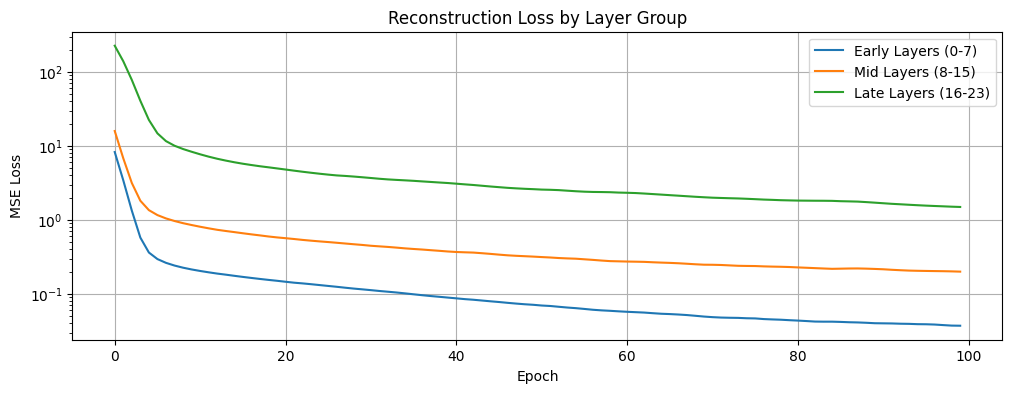

In [ ]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

Note that all experimentation uses the same baseline code, but has modifications made to fit the particular experiment.

# Experimentation at All Layers

The experiment here is to see if creating a more complex architecture for later layers can help decrease the major loss discrepany we are currently seeing. First off, this will require a simple modification to the init for Autoencoder to create a more complex architecture for late layers. Second, if that shows promise, the complexity of late can be "hand me downed" to the mid layers and the late layers become even more complex. If either situations look like they need even more help, in the get_hidden function the return of the scaling of how many hidden layers to use can be amped to be even larger for later ones. Also, the learning rate is being increase naively for each layer, we could instead introduce a system of a learning rate scheduler, eg. ReduceLROnPlateau, which would decrease the learning rate upon plateaued loss. Or, in general the starting point and alteration of learning rate between layers should be explored, stored, and analyzed in isolation after trying the architecture changes.

There is also the possibility that GELU is not appropriate for later layers since some activation functions might have better feature represenations at deeper layers. A potential thought here is to replace the Gaussian Error Linear Unit (GELU) for later layers with ReLU or LeakyReLU.

## Increasingly complex architecture implementation and results

The only difference here is in the init of the Autoencoder class

 10%|█         | 10/100 [01:57<17:56, 11.96s/it]


Epoch 10
Train Losses - Early: 0.215, Mid: 0.852, Late: 10.183
Test Losses  - Early: 1.165, Mid: 4.037, Late: 24.971


 20%|██        | 20/100 [03:52<15:20, 11.51s/it]


Epoch 20
Train Losses - Early: 0.151, Mid: 0.578, Late: 6.229
Test Losses  - Early: 1.037, Mid: 3.463, Late: 19.165


 30%|███       | 30/100 [05:48<13:29, 11.56s/it]


Epoch 30
Train Losses - Early: 0.116, Mid: 0.454, Late: 4.890
Test Losses  - Early: 0.967, Mid: 3.194, Late: 17.540


 40%|████      | 40/100 [07:43<11:28, 11.48s/it]


Epoch 40
Train Losses - Early: 0.090, Mid: 0.375, Late: 4.116
Test Losses  - Early: 0.932, Mid: 3.062, Late: 16.564


 50%|█████     | 50/100 [09:37<09:32, 11.44s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.314, Late: 3.588
Test Losses  - Early: 0.913, Mid: 2.967, Late: 16.852


 60%|██████    | 60/100 [11:31<07:39, 11.50s/it]


Epoch 60
Train Losses - Early: 0.058, Mid: 0.280, Late: 3.226
Test Losses  - Early: 0.910, Mid: 2.940, Late: 15.874


 70%|███████   | 70/100 [13:25<05:43, 11.46s/it]


Epoch 70
Train Losses - Early: 0.050, Mid: 0.248, Late: 2.939
Test Losses  - Early: 0.913, Mid: 2.895, Late: 16.096


 80%|████████  | 80/100 [15:19<03:49, 11.45s/it]


Epoch 80
Train Losses - Early: 0.044, Mid: 0.228, Late: 2.686
Test Losses  - Early: 0.908, Mid: 2.871, Late: 15.818


 90%|█████████ | 90/100 [17:16<01:59, 11.99s/it]


Epoch 90
Train Losses - Early: 0.040, Mid: 0.215, Late: 2.454
Test Losses  - Early: 0.912, Mid: 2.867, Late: 16.603


100%|██████████| 100/100 [19:11<00:00, 11.51s/it]


Epoch 100
Train Losses - Early: 0.038, Mid: 0.202, Late: 2.312
Test Losses  - Early: 0.918, Mid: 2.859, Late: 15.784


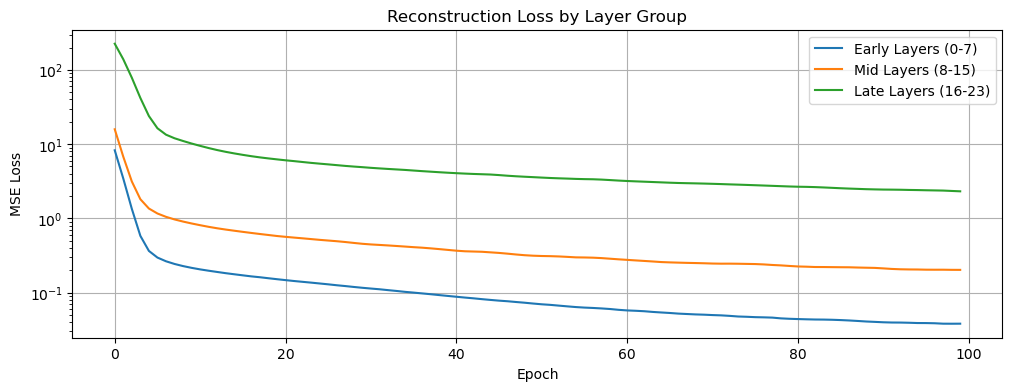

In [ ]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction for early and middle layers
        d_mid = (d_in + d_hidden) // 2

        # More gradual dimension reduction for late layers, also affords more layers
        # this is the one third point, this is closer to d_in
        d_onethird_to_hidden = (2 * d_in + d_hidden) // 3 
        # this is the two third point, this is closer to d_hidden
        d_twothird_to_hidden = (d_in + 2 * d_hidden) // 3
        
        # This is a modest enhancement of complexity
        if layer_idx >= 16:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_onethird_to_hidden),
                nn.LayerNorm(d_onethird_to_hidden),
                nn.GELU(),
                nn.Linear(d_onethird_to_hidden, d_twothird_to_hidden),
                nn.LayerNorm(d_twothird_to_hidden),
                nn.GELU(),
                nn.Linear(d_twothird_to_hidden, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU()
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_twothird_to_hidden),
                nn.LayerNorm(d_twothird_to_hidden),
                nn.GELU(),
                nn.Linear(d_twothird_to_hidden, d_onethird_to_hidden),
                nn.LayerNorm(d_onethird_to_hidden),
                nn.GELU(),
                nn.Linear(d_onethird_to_hidden, d_in)
            )
        # For early and mid keep the original architecture
        else:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU()
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_in)
            )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Marginally worse

## Hidden layer increase

The only difference here is in the get_hidden function.

 10%|█         | 10/100 [01:49<16:24, 10.94s/it]


Epoch 10
Train Losses - Early: 0.214, Mid: 0.853, Late: 7.543
Test Losses  - Early: 1.163, Mid: 4.037, Late: 21.336


 20%|██        | 20/100 [03:38<14:34, 10.93s/it]


Epoch 20
Train Losses - Early: 0.150, Mid: 0.583, Late: 4.481
Test Losses  - Early: 1.037, Mid: 3.477, Late: 16.006


 30%|███       | 30/100 [05:27<12:42, 10.90s/it]


Epoch 30
Train Losses - Early: 0.115, Mid: 0.458, Late: 3.446
Test Losses  - Early: 0.964, Mid: 3.198, Late: 14.206


 40%|████      | 40/100 [07:15<10:49, 10.83s/it]


Epoch 40
Train Losses - Early: 0.090, Mid: 0.375, Late: 2.662
Test Losses  - Early: 0.936, Mid: 3.050, Late: 13.263


 50%|█████     | 50/100 [09:06<09:33, 11.47s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.314, Late: 2.274
Test Losses  - Early: 0.919, Mid: 2.961, Late: 12.524


 60%|██████    | 60/100 [11:02<07:49, 11.74s/it]


Epoch 60
Train Losses - Early: 0.059, Mid: 0.280, Late: 1.861
Test Losses  - Early: 0.915, Mid: 2.915, Late: 11.927


 70%|███████   | 70/100 [12:56<05:44, 11.49s/it]


Epoch 70
Train Losses - Early: 0.050, Mid: 0.247, Late: 1.640
Test Losses  - Early: 0.914, Mid: 2.875, Late: 11.224


 80%|████████  | 80/100 [14:50<03:51, 11.57s/it]


Epoch 80
Train Losses - Early: 0.045, Mid: 0.230, Late: 1.445
Test Losses  - Early: 0.913, Mid: 2.866, Late: 11.006


 90%|█████████ | 90/100 [16:45<01:55, 11.50s/it]


Epoch 90
Train Losses - Early: 0.041, Mid: 0.213, Late: 1.260
Test Losses  - Early: 0.915, Mid: 2.836, Late: 10.563


100%|██████████| 100/100 [18:41<00:00, 11.21s/it]


Epoch 100
Train Losses - Early: 0.038, Mid: 0.202, Late: 1.130
Test Losses  - Early: 0.913, Mid: 2.833, Late: 10.381


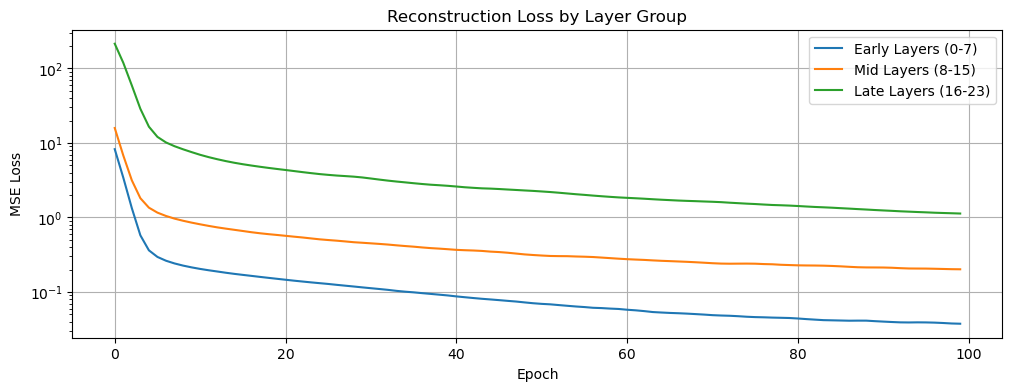

In [ ]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 5  # Increased from 3 to 5
    else:
        return 6  # Increased from 4 to 6

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction for early and middle layers
        d_mid = (d_in + d_hidden) // 2

        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU()
        )
            
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in)
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Marginally better

# Experimentation on the Final Four Layers

The final four layers have the highest loss and are capturing the most complex information, so apply hyperparameter experimentation to improve their loss.

## Baseline

This is similar to previous code, but the Late layers are split up into Final Four and Mid Late.

 10%|█         | 10/100 [01:40<14:48,  9.87s/it]


Epoch 10
Train Losses - Early: 0.273, Mid: 1.091, Mid Late: 3.828, Final Four: 17.833
Test Losses  - Early: 1.452, Mid: 5.056, Mid Late: 13.932, Final Four: 44.182


 20%|██        | 20/100 [03:17<12:58,  9.73s/it]


Epoch 20
Train Losses - Early: 0.192, Mid: 0.741, Mid Late: 2.516, Final Four: 10.216
Test Losses  - Early: 1.290, Mid: 4.342, Mid Late: 11.838, Final Four: 30.627


 30%|███       | 30/100 [04:56<11:53, 10.20s/it]


Epoch 30
Train Losses - Early: 0.149, Mid: 0.593, Mid Late: 1.962, Final Four: 7.740
Test Losses  - Early: 1.202, Mid: 4.009, Mid Late: 10.757, Final Four: 27.392


 40%|████      | 40/100 [06:37<10:07, 10.12s/it]


Epoch 40
Train Losses - Early: 0.119, Mid: 0.494, Mid Late: 1.654, Final Four: 6.427
Test Losses  - Early: 1.160, Mid: 3.818, Mid Late: 10.161, Final Four: 24.641


 50%|█████     | 50/100 [08:15<08:11,  9.82s/it]


Epoch 50
Train Losses - Early: 0.095, Mid: 0.417, Mid Late: 1.406, Final Four: 5.420
Test Losses  - Early: 1.135, Mid: 3.698, Mid Late: 9.703, Final Four: 23.052


 60%|██████    | 60/100 [09:52<06:29,  9.73s/it]


Epoch 60
Train Losses - Early: 0.078, Mid: 0.363, Mid Late: 1.245, Final Four: 4.745
Test Losses  - Early: 1.130, Mid: 3.623, Mid Late: 9.475, Final Four: 22.204


 70%|███████   | 70/100 [11:29<04:52,  9.76s/it]


Epoch 70
Train Losses - Early: 0.067, Mid: 0.326, Mid Late: 1.080, Final Four: 4.114
Test Losses  - Early: 1.123, Mid: 3.561, Mid Late: 9.190, Final Four: 20.744


 80%|████████  | 80/100 [13:06<03:15,  9.75s/it]


Epoch 80
Train Losses - Early: 0.059, Mid: 0.301, Mid Late: 1.003, Final Four: 3.727
Test Losses  - Early: 1.125, Mid: 3.554, Mid Late: 9.063, Final Four: 20.870


 90%|█████████ | 90/100 [14:43<01:37,  9.75s/it]


Epoch 90
Train Losses - Early: 0.053, Mid: 0.272, Mid Late: 0.942, Final Four: 3.311
Test Losses  - Early: 1.125, Mid: 3.514, Mid Late: 9.056, Final Four: 19.268


100%|██████████| 100/100 [16:20<00:00,  9.81s/it]


Epoch 100
Train Losses - Early: 0.048, Mid: 0.260, Mid Late: 0.847, Final Four: 2.995
Test Losses  - Early: 1.121, Mid: 3.492, Mid Late: 8.891, Final Four: 18.826


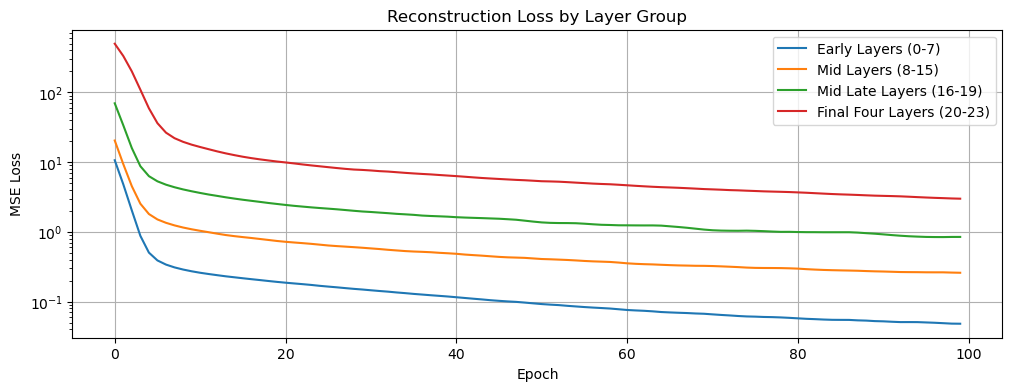

In [6]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

## Increase Hidden Layers for Final Four

The change here is in get_hidden

 10%|█         | 10/100 [01:40<15:02, 10.02s/it]


Epoch 10
Train Losses - Early: 0.273, Mid: 1.091, Mid Late: 3.866, Final Four: 15.857
Test Losses  - Early: 1.451, Mid: 5.045, Mid Late: 13.951, Final Four: 40.309


 20%|██        | 20/100 [03:20<13:20, 10.00s/it]


Epoch 20
Train Losses - Early: 0.192, Mid: 0.740, Mid Late: 2.556, Final Four: 9.275
Test Losses  - Early: 1.290, Mid: 4.326, Mid Late: 11.903, Final Four: 29.197


 30%|███       | 30/100 [05:01<11:44, 10.07s/it]


Epoch 30
Train Losses - Early: 0.150, Mid: 0.588, Mid Late: 1.992, Final Four: 7.107
Test Losses  - Early: 1.204, Mid: 3.985, Mid Late: 10.713, Final Four: 26.034


 40%|████      | 40/100 [06:40<09:56,  9.94s/it]


Epoch 40
Train Losses - Early: 0.117, Mid: 0.487, Mid Late: 1.655, Final Four: 5.719
Test Losses  - Early: 1.160, Mid: 3.799, Mid Late: 10.100, Final Four: 24.403


 50%|█████     | 50/100 [08:19<08:14,  9.89s/it]


Epoch 50
Train Losses - Early: 0.093, Mid: 0.425, Mid Late: 1.445, Final Four: 4.767
Test Losses  - Early: 1.137, Mid: 3.716, Mid Late: 9.837, Final Four: 21.964


 60%|██████    | 60/100 [09:57<06:34,  9.85s/it]


Epoch 60
Train Losses - Early: 0.077, Mid: 0.360, Mid Late: 1.256, Final Four: 4.064
Test Losses  - Early: 1.126, Mid: 3.619, Mid Late: 9.477, Final Four: 21.134


 70%|███████   | 70/100 [11:35<04:55,  9.86s/it]


Epoch 70
Train Losses - Early: 0.065, Mid: 0.322, Mid Late: 1.122, Final Four: 3.491
Test Losses  - Early: 1.128, Mid: 3.569, Mid Late: 9.314, Final Four: 19.939


 80%|████████  | 80/100 [13:13<03:17,  9.86s/it]


Epoch 80
Train Losses - Early: 0.057, Mid: 0.298, Mid Late: 1.012, Final Four: 3.054
Test Losses  - Early: 1.126, Mid: 3.541, Mid Late: 9.124, Final Four: 19.402


 90%|█████████ | 90/100 [14:51<01:38,  9.84s/it]


Epoch 90
Train Losses - Early: 0.052, Mid: 0.271, Mid Late: 0.939, Final Four: 2.728
Test Losses  - Early: 1.129, Mid: 3.507, Mid Late: 9.063, Final Four: 18.543


100%|██████████| 100/100 [16:29<00:00,  9.90s/it]


Epoch 100
Train Losses - Early: 0.048, Mid: 0.261, Mid Late: 0.877, Final Four: 2.377
Test Losses  - Early: 1.128, Mid: 3.501, Mid Late: 9.006, Final Four: 18.246


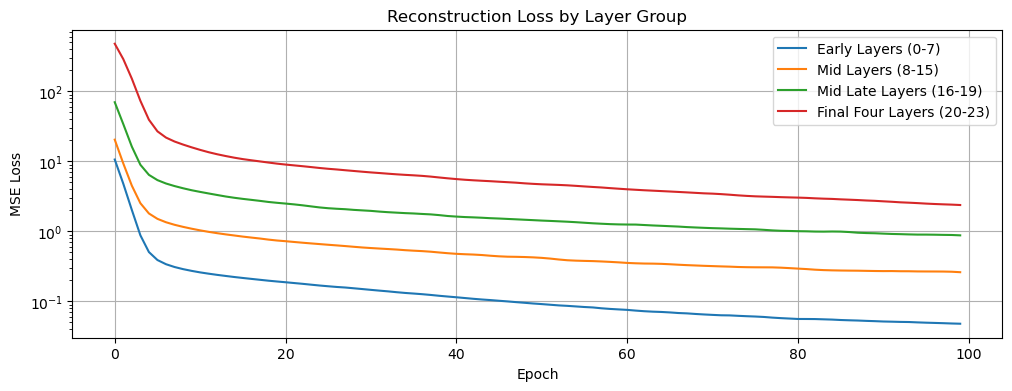

In [ ]:
# Scale the final four hidden features more aggressively
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 19:
        return 3
    elif i == 20:
        return 4
    elif i == 21:
        return 5
    elif i == 22:
        return 6
    else:
        return 7

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: marginal improvement

## Increase Activation Layers for Final Four

The change here is in the init of Autoencoder

 10%|█         | 10/100 [01:44<15:36, 10.40s/it]


Epoch 10
Train Losses - Early: 0.273, Mid: 1.093, Mid Late: 3.874, Final Four: 22.571
Test Losses  - Early: 1.453, Mid: 5.052, Mid Late: 13.958, Final Four: 48.348


 20%|██        | 20/100 [03:29<13:52, 10.40s/it]


Epoch 20
Train Losses - Early: 0.193, Mid: 0.741, Mid Late: 2.563, Final Four: 13.125
Test Losses  - Early: 1.292, Mid: 4.344, Mid Late: 11.873, Final Four: 34.838


 30%|███       | 30/100 [05:12<12:05, 10.36s/it]


Epoch 30
Train Losses - Early: 0.149, Mid: 0.587, Mid Late: 1.986, Final Four: 10.172
Test Losses  - Early: 1.200, Mid: 3.990, Mid Late: 10.690, Final Four: 30.917


 40%|████      | 40/100 [06:56<10:22, 10.38s/it]


Epoch 40
Train Losses - Early: 0.118, Mid: 0.489, Mid Late: 1.644, Final Four: 8.644
Test Losses  - Early: 1.151, Mid: 3.818, Mid Late: 10.045, Final Four: 29.578


 50%|█████     | 50/100 [08:39<08:39, 10.40s/it]


Epoch 50
Train Losses - Early: 0.095, Mid: 0.419, Mid Late: 1.471, Final Four: 7.568
Test Losses  - Early: 1.131, Mid: 3.704, Mid Late: 9.787, Final Four: 29.251


 60%|██████    | 60/100 [10:23<06:55, 10.38s/it]


Epoch 60
Train Losses - Early: 0.078, Mid: 0.365, Mid Late: 1.245, Final Four: 6.775
Test Losses  - Early: 1.120, Mid: 3.626, Mid Late: 9.417, Final Four: 28.150


 70%|███████   | 70/100 [12:07<05:13, 10.46s/it]


Epoch 70
Train Losses - Early: 0.066, Mid: 0.323, Mid Late: 1.126, Final Four: 6.169
Test Losses  - Early: 1.119, Mid: 3.573, Mid Late: 9.205, Final Four: 27.990


 80%|████████  | 80/100 [13:51<03:28, 10.44s/it]


Epoch 80
Train Losses - Early: 0.058, Mid: 0.298, Mid Late: 1.004, Final Four: 5.602
Test Losses  - Early: 1.120, Mid: 3.552, Mid Late: 9.040, Final Four: 27.213


 90%|█████████ | 90/100 [15:34<01:44, 10.41s/it]


Epoch 90
Train Losses - Early: 0.053, Mid: 0.271, Mid Late: 0.956, Final Four: 5.147
Test Losses  - Early: 1.117, Mid: 3.509, Mid Late: 9.017, Final Four: 27.099


100%|██████████| 100/100 [17:21<00:00, 10.41s/it]


Epoch 100
Train Losses - Early: 0.049, Mid: 0.259, Mid Late: 0.854, Final Four: 4.774
Test Losses  - Early: 1.121, Mid: 3.501, Mid Late: 8.853, Final Four: 28.300


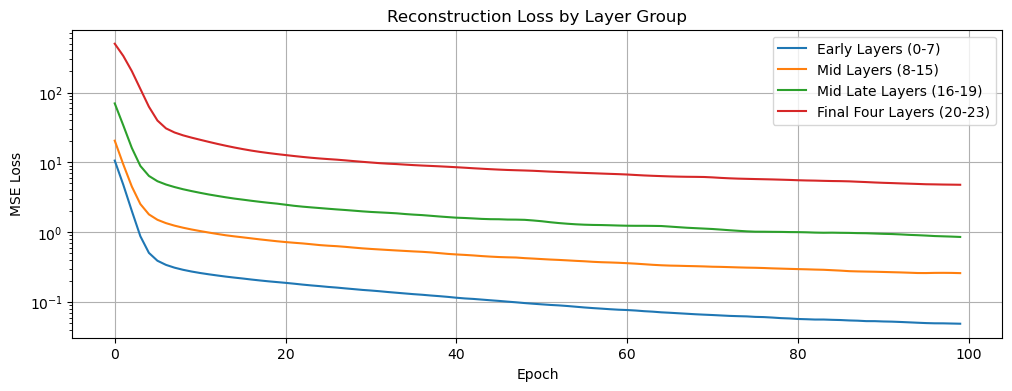

In [8]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction for early and middle layers
        d_mid = (d_in + d_hidden) // 2

        # More gradual dimension reduction for late layers, also affords more layers
        # this is the one third point, this is closer to d_in
        d_onethird_to_hidden = (2 * d_in + d_hidden) // 3 
        # this is the two third point, this is closer to d_hidden
        d_twothird_to_hidden = (d_in + 2 * d_hidden) // 3
        
        # This is a modest enhancement of complexity
        if layer_idx >= 20:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_onethird_to_hidden),
                nn.LayerNorm(d_onethird_to_hidden),
                nn.GELU(),
                nn.Linear(d_onethird_to_hidden, d_twothird_to_hidden),
                nn.LayerNorm(d_twothird_to_hidden),
                nn.GELU(),
                nn.Linear(d_twothird_to_hidden, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU()
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_twothird_to_hidden),
                nn.LayerNorm(d_twothird_to_hidden),
                nn.GELU(),
                nn.Linear(d_twothird_to_hidden, d_onethird_to_hidden),
                nn.LayerNorm(d_onethird_to_hidden),
                nn.GELU(),
                nn.Linear(d_onethird_to_hidden, d_in)
            )
        # For early and mid keep the original architecture
        else:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU()
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_in)
            )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Significantly worse

## Modify Learning Rate for Final Four

The change here is in the definition of lrs

 10%|█         | 10/100 [01:41<15:08, 10.09s/it]


Epoch 10
Train Losses - Early: 0.273, Mid: 1.091, Mid Late: 3.824, Final Four: 13.406
Test Losses  - Early: 1.454, Mid: 5.059, Mid Late: 13.932, Final Four: 35.731


 20%|██        | 20/100 [03:19<13:04,  9.81s/it]


Epoch 20
Train Losses - Early: 0.193, Mid: 0.745, Mid Late: 2.514, Final Four: 8.608
Test Losses  - Early: 1.290, Mid: 4.352, Mid Late: 11.800, Final Four: 28.206


 30%|███       | 30/100 [04:57<11:27,  9.82s/it]


Epoch 30
Train Losses - Early: 0.149, Mid: 0.589, Mid Late: 1.981, Final Four: 6.500
Test Losses  - Early: 1.202, Mid: 3.996, Mid Late: 10.723, Final Four: 25.256


 40%|████      | 40/100 [06:35<09:49,  9.82s/it]


Epoch 40
Train Losses - Early: 0.118, Mid: 0.493, Mid Late: 1.653, Final Four: 5.322
Test Losses  - Early: 1.155, Mid: 3.811, Mid Late: 10.117, Final Four: 22.977


 50%|█████     | 50/100 [08:12<08:11,  9.82s/it]


Epoch 50
Train Losses - Early: 0.095, Mid: 0.418, Mid Late: 1.407, Final Four: 4.331
Test Losses  - Early: 1.131, Mid: 3.692, Mid Late: 9.663, Final Four: 21.422


 60%|██████    | 60/100 [09:54<06:49, 10.23s/it]


Epoch 60
Train Losses - Early: 0.078, Mid: 0.365, Mid Late: 1.218, Final Four: 3.768
Test Losses  - Early: 1.122, Mid: 3.625, Mid Late: 9.333, Final Four: 20.573


 70%|███████   | 70/100 [11:40<05:18, 10.61s/it]


Epoch 70
Train Losses - Early: 0.067, Mid: 0.318, Mid Late: 1.133, Final Four: 3.267
Test Losses  - Early: 1.120, Mid: 3.567, Mid Late: 9.250, Final Four: 19.737


 80%|████████  | 80/100 [13:26<03:34, 10.73s/it]


Epoch 80
Train Losses - Early: 0.058, Mid: 0.296, Mid Late: 1.006, Final Four: 2.893
Test Losses  - Early: 1.118, Mid: 3.547, Mid Late: 9.092, Final Four: 19.219


 90%|█████████ | 90/100 [15:14<01:48, 10.89s/it]


Epoch 90
Train Losses - Early: 0.053, Mid: 0.273, Mid Late: 0.937, Final Four: 2.590
Test Losses  - Early: 1.118, Mid: 3.519, Mid Late: 9.028, Final Four: 19.251


100%|██████████| 100/100 [17:00<00:00, 10.21s/it]


Epoch 100
Train Losses - Early: 0.049, Mid: 0.257, Mid Late: 0.841, Final Four: 2.367
Test Losses  - Early: 1.122, Mid: 3.497, Mid Late: 8.918, Final Four: 18.840


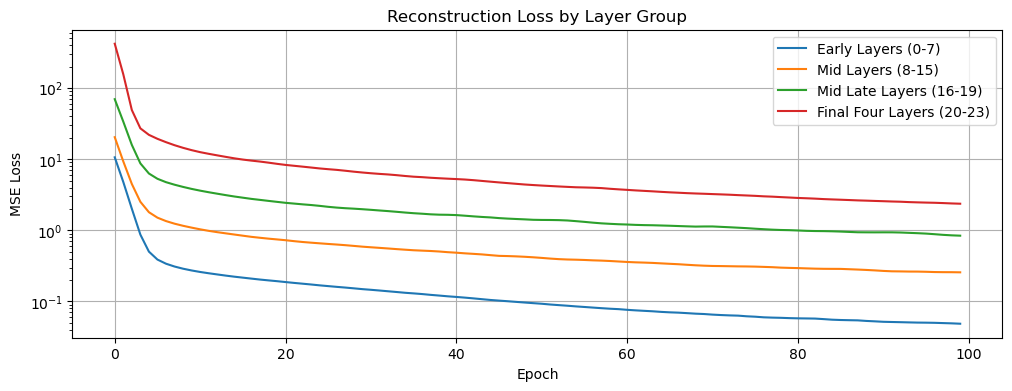

In [9]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i / 24) for i in range(n_layers)]
lrs[20:] = [lr * 2 for lr in lrs[20:]]  # Double the learning rate for the final four layers
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Marginal improvement

## Add More Dropout for Final Four

The change here is in the init of Autoencoder

 10%|█         | 10/100 [01:46<16:02, 10.70s/it]


Epoch 10
Train Losses - Early: 0.271, Mid: 1.094, Mid Late: 3.844, Final Four: 25.018
Test Losses  - Early: 1.450, Mid: 5.058, Mid Late: 13.925, Final Four: 48.967


 20%|██        | 20/100 [03:32<14:09, 10.62s/it]


Epoch 20
Train Losses - Early: 0.191, Mid: 0.744, Mid Late: 2.536, Final Four: 18.846
Test Losses  - Early: 1.291, Mid: 4.334, Mid Late: 11.816, Final Four: 39.172


 30%|███       | 30/100 [05:18<12:22, 10.61s/it]


Epoch 30
Train Losses - Early: 0.148, Mid: 0.598, Mid Late: 1.989, Final Four: 17.052
Test Losses  - Early: 1.203, Mid: 4.008, Mid Late: 10.794, Final Four: 35.241


 40%|████      | 40/100 [07:04<10:36, 10.61s/it]


Epoch 40
Train Losses - Early: 0.117, Mid: 0.491, Mid Late: 1.660, Final Four: 16.136
Test Losses  - Early: 1.154, Mid: 3.813, Mid Late: 10.088, Final Four: 33.268


 50%|█████     | 50/100 [08:50<08:52, 10.65s/it]


Epoch 50
Train Losses - Early: 0.093, Mid: 0.420, Mid Late: 1.422, Final Four: 15.521
Test Losses  - Early: 1.136, Mid: 3.706, Mid Late: 9.770, Final Four: 32.357


 60%|██████    | 60/100 [10:36<07:10, 10.75s/it]


Epoch 60
Train Losses - Early: 0.077, Mid: 0.364, Mid Late: 1.243, Final Four: 15.035
Test Losses  - Early: 1.129, Mid: 3.622, Mid Late: 9.386, Final Four: 31.714


 70%|███████   | 70/100 [12:22<05:17, 10.57s/it]


Epoch 70
Train Losses - Early: 0.065, Mid: 0.323, Mid Late: 1.111, Final Four: 14.578
Test Losses  - Early: 1.126, Mid: 3.591, Mid Late: 9.168, Final Four: 30.869


 80%|████████  | 80/100 [14:10<03:34, 10.72s/it]


Epoch 80
Train Losses - Early: 0.057, Mid: 0.296, Mid Late: 0.993, Final Four: 14.198
Test Losses  - Early: 1.128, Mid: 3.549, Mid Late: 9.008, Final Four: 30.311


 90%|█████████ | 90/100 [15:55<01:45, 10.52s/it]


Epoch 90
Train Losses - Early: 0.052, Mid: 0.275, Mid Late: 0.918, Final Four: 13.856
Test Losses  - Early: 1.123, Mid: 3.523, Mid Late: 8.959, Final Four: 30.013


100%|██████████| 100/100 [17:41<00:00, 10.61s/it]


Epoch 100
Train Losses - Early: 0.049, Mid: 0.258, Mid Late: 0.859, Final Four: 13.555
Test Losses  - Early: 1.135, Mid: 3.500, Mid Late: 8.962, Final Four: 29.610


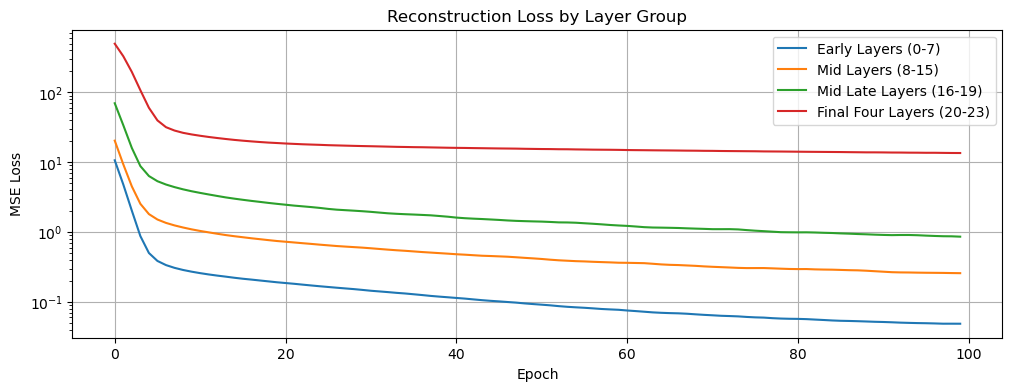

In [10]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256, dropout_prob = 0.3):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction for early and middle layers
        d_mid = (d_in + d_hidden) // 2

        
        # This is a modest enhancement of complexity
        if layer_idx >= 20:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Dropout(dropout_prob), # DROPOUT
                nn.Linear(d_mid, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU(),
                nn.Dropout(dropout_prob) # DROPOUT
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Dropout(dropout_prob), # DROPOUT
                nn.Linear(d_mid, d_in)
            )
        # For early and mid keep the original architecture
        else:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU()
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_in)
            )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Significantly worse

## Best of Experiments: Enhanced Learning Rate and More Hidden Layers

### Experimental combinations

 10%|█         | 10/100 [01:47<16:23, 10.93s/it]


Epoch 10
Train Losses - Early: 0.272, Mid: 1.096, Mid Late: 3.841, Final Four: 13.132
Test Losses  - Early: 1.452, Mid: 5.063, Mid Late: 13.928, Final Four: 34.207


 20%|██        | 20/100 [03:35<14:18, 10.74s/it]


Epoch 20
Train Losses - Early: 0.192, Mid: 0.747, Mid Late: 2.529, Final Four: 8.238
Test Losses  - Early: 1.292, Mid: 4.340, Mid Late: 11.815, Final Four: 27.126


 30%|███       | 30/100 [05:22<12:40, 10.87s/it]


Epoch 30
Train Losses - Early: 0.149, Mid: 0.593, Mid Late: 1.994, Final Four: 6.203
Test Losses  - Early: 1.200, Mid: 4.008, Mid Late: 10.759, Final Four: 24.688


 40%|████      | 40/100 [07:08<10:38, 10.64s/it]


Epoch 40
Train Losses - Early: 0.118, Mid: 0.494, Mid Late: 1.649, Final Four: 4.872
Test Losses  - Early: 1.153, Mid: 3.814, Mid Late: 10.053, Final Four: 22.124


 50%|█████     | 50/100 [08:56<08:59, 10.80s/it]


Epoch 50
Train Losses - Early: 0.095, Mid: 0.424, Mid Late: 1.405, Final Four: 3.955
Test Losses  - Early: 1.135, Mid: 3.712, Mid Late: 9.700, Final Four: 20.987


 60%|██████    | 60/100 [10:45<07:21, 11.05s/it]


Epoch 60
Train Losses - Early: 0.077, Mid: 0.360, Mid Late: 1.215, Final Four: 3.403
Test Losses  - Early: 1.123, Mid: 3.633, Mid Late: 9.385, Final Four: 20.505


 70%|███████   | 70/100 [12:25<05:02, 10.08s/it]


Epoch 70
Train Losses - Early: 0.066, Mid: 0.323, Mid Late: 1.125, Final Four: 2.787
Test Losses  - Early: 1.117, Mid: 3.575, Mid Late: 9.359, Final Four: 19.061


 80%|████████  | 80/100 [14:06<03:21, 10.07s/it]


Epoch 80
Train Losses - Early: 0.058, Mid: 0.298, Mid Late: 0.992, Final Four: 2.446
Test Losses  - Early: 1.120, Mid: 3.546, Mid Late: 9.075, Final Four: 18.743


 90%|█████████ | 90/100 [15:46<01:40, 10.09s/it]


Epoch 90
Train Losses - Early: 0.052, Mid: 0.276, Mid Late: 0.931, Final Four: 2.310
Test Losses  - Early: 1.118, Mid: 3.525, Mid Late: 8.990, Final Four: 19.383


100%|██████████| 100/100 [17:26<00:00, 10.47s/it]


Epoch 100
Train Losses - Early: 0.048, Mid: 0.257, Mid Late: 0.878, Final Four: 1.950
Test Losses  - Early: 1.116, Mid: 3.502, Mid Late: 9.019, Final Four: 17.695


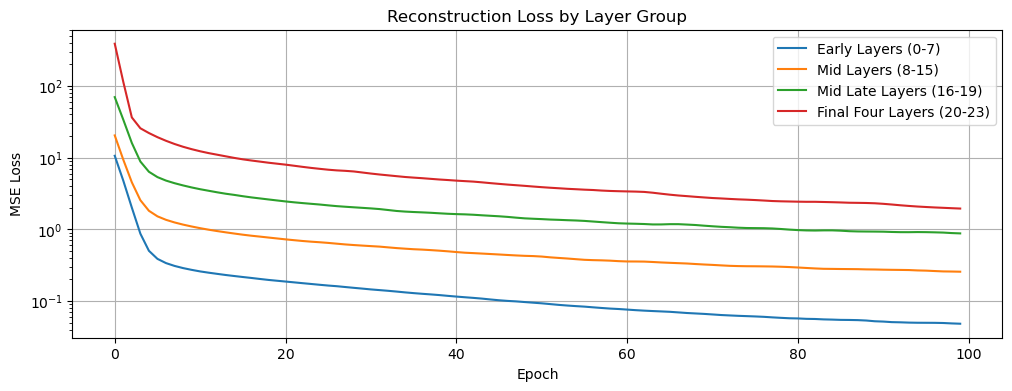

In [11]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 19:
        return 3
    elif i == 20:
        return 4
    elif i == 21:
        return 5
    elif i == 22:
        return 6
    else:
        return 7

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h) 

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i / 24) for i in range(n_layers)]
lrs[20:] = [lr * 2 for lr in lrs[20:]]  # Double the learning rate for the final four layers
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Roughly 5% improvement over baseline

# Incorporating Improvements in Downstream Results

The autoencoders with enhanced learning rate and more hidden layers are passed onto the siamese network.

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self, mlp):
        super().__init__()
        self.mlp = mlp

    def forward(self, x1, x2):
        h1 = self.mlp(x1)
        h2 = self.mlp(x2)
        return F.cosine_similarity(h1, h2, dim=-1)

class LayerwiseSiameseNetworks(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256):
        super().__init__()
        self.n_layers = n_layers
        self.layer_nets = nn.ModuleList([SiameseNetwork(encoders[i]) for i in range(n_layers)])

    def forward(self, x1, x2):
        similarities = []
        for layer in range(self.n_layers):
            net_at_layer = self.layer_nets[layer].cuda()
            # Get the activations at the given layer
            x1_l = x1[:, layer].cuda()
            x2_l = x2[:, layer].cuda()

            sim_at_layer = net_at_layer(x1_l, x2_l)
            # print(sim_at_layer.shape)
            similarities.append(sim_at_layer)

        return torch.stack(similarities, dim=-1)

class SimilarityLearner(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256, d_out_hidden=512, dropout=0.1):
        super().__init__()
        self.layer_nets = LayerwiseSiameseNetworks(encoders, n_layers, d_in, d_hidden)

        self.mlp = nn.Sequential(
            nn.Linear(n_layers, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, 1),
            nn.Hardsigmoid()
        )

    def forward(self, x1, x2, training=True):
        layerwise_similarities = self.layer_nets(x1, x2)
        similarity = self.mlp(layerwise_similarities)
        return similarity.squeeze()

In [13]:
from copy import deepcopy
cloned_encoders = [deepcopy(e).encode for e in encoders]

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=512).to('cuda:0')
# similarity_learner = SimilarityLearner([Autoencoder(i) for i in range(24)], d_hidden=512).to('cuda:0')
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-5)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=32):
    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = first_acts[start_idx:end_idx].cuda()
        x2_batch = second_acts[start_idx:end_idx].cuda()
        scores_batch = scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)
        
        loss = F.mse_loss(sims, scores_batch)        
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(100)):
    # Training
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Loss: {loss:.4f}")
            print(f"Train correlation: {train_corr:.4f}")
            print(f"Test correlation: {test_corr:.4f}\n")

 10%|█         | 10/100 [02:11<19:34, 13.05s/it]

Epoch 10
Loss: 0.0173
Train correlation: 0.8987
Test correlation: 0.6882



 20%|██        | 20/100 [04:23<17:31, 13.15s/it]

Epoch 20
Loss: 0.0097
Train correlation: 0.9466
Test correlation: 0.7127



 30%|███       | 30/100 [06:35<15:28, 13.26s/it]

Epoch 30
Loss: 0.0048
Train correlation: 0.9651
Test correlation: 0.7161



 40%|████      | 40/100 [08:46<13:17, 13.29s/it]

Epoch 40
Loss: 0.0034
Train correlation: 0.9688
Test correlation: 0.7248



 50%|█████     | 50/100 [10:56<11:00, 13.20s/it]

Epoch 50
Loss: 0.0021
Train correlation: 0.9524
Test correlation: 0.7199



 60%|██████    | 60/100 [13:08<08:44, 13.12s/it]

Epoch 60
Loss: 0.0023
Train correlation: 0.9649
Test correlation: 0.6938



 70%|███████   | 70/100 [15:20<06:34, 13.14s/it]

Epoch 70
Loss: 0.0021
Train correlation: 0.9822
Test correlation: 0.7354



 80%|████████  | 80/100 [17:29<04:18, 12.95s/it]

Epoch 80
Loss: 0.0012
Train correlation: 0.9914
Test correlation: 0.7432



 90%|█████████ | 90/100 [19:38<02:10, 13.07s/it]

Epoch 90
Loss: 0.0026
Train correlation: 0.9722
Test correlation: 0.7104



100%|██████████| 100/100 [21:48<00:00, 13.08s/it]

Epoch 100
Loss: 0.0010
Train correlation: 0.9881
Test correlation: 0.7348



In [14]:
test_preds = best_model(first_test.cuda(), second_test.cuda(), training=False)
test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]
print(test_corr)

tensor(0.7432, grad_fn=<SelectBackward0>)


In [15]:
param_count = sum([w.numel() for w in similarity_learner.parameters()])
f"This model has {param_count} parameters!"

'This model has 34263041 parameters!'

### End result: 4 million more parameters and no significant difference in downstream performance improvement. Overall, this provides evidence that the bottleneck in performance based on current architecture is not the autoencoders as previously thought.

# Further Experimentation at All Layers

## Implementing a Learning Rate Scheduler

PyTorch provides several learning rate schedulers:
- Exponential Decay (ExponentialLR): Gradually reduces the learning rate by a factor after every epoch.
- Cosine Annealing (CosineAnnealingLR): Reduces the learning rate following a cosine function.
- Reduce on Plateau (ReduceLROnPlateau): Reduces the learning rate when a metric (e.g., validation loss) stops improving.

Cosine annealing is the most intriguing since deeper layers might benefit from periodic resets to higher learning rates.

### Using Cosine Annealing

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

  4%|▍         | 10/250 [03:42<1:29:01, 22.26s/it]


Epoch 10
Train Losses - Early: 0.290, Mid: 1.229, Late: 9.904
Test Losses  - Early: 1.441, Mid: 5.264, Late: 27.422


  8%|▊         | 20/250 [07:24<1:25:37, 22.34s/it]


Epoch 20
Train Losses - Early: 0.245, Mid: 1.033, Late: 7.698
Test Losses  - Early: 1.355, Mid: 4.883, Late: 23.422


 12%|█▏        | 30/250 [11:08<1:23:07, 22.67s/it]


Epoch 30
Train Losses - Early: 0.235, Mid: 0.989, Late: 7.343
Test Losses  - Early: 1.337, Mid: 4.809, Late: 22.884


 16%|█▌        | 40/250 [14:51<1:18:08, 22.33s/it]


Epoch 40
Train Losses - Early: 0.232, Mid: 0.980, Late: 7.242
Test Losses  - Early: 1.330, Mid: 4.775, Late: 22.622


 20%|██        | 50/250 [18:34<1:14:13, 22.27s/it]


Epoch 50
Train Losses - Early: 0.214, Mid: 0.914, Late: 6.744
Test Losses  - Early: 1.306, Mid: 4.647, Late: 21.642


 24%|██▍       | 60/250 [22:17<1:10:54, 22.39s/it]


Epoch 60
Train Losses - Early: 0.189, Mid: 0.834, Late: 6.164
Test Losses  - Early: 1.282, Mid: 4.529, Late: 21.173


 28%|██▊       | 70/250 [26:02<1:08:00, 22.67s/it]


Epoch 70
Train Losses - Early: 0.170, Mid: 0.776, Late: 5.741
Test Losses  - Early: 1.272, Mid: 4.445, Late: 20.710


 32%|███▏      | 80/250 [29:46<1:03:23, 22.37s/it]


Epoch 80
Train Losses - Early: 0.158, Mid: 0.731, Late: 5.450
Test Losses  - Early: 1.254, Mid: 4.379, Late: 20.245


 36%|███▌      | 90/250 [33:30<59:48, 22.43s/it]  


Epoch 90
Train Losses - Early: 0.153, Mid: 0.714, Late: 5.340
Test Losses  - Early: 1.250, Mid: 4.356, Late: 20.073


 40%|████      | 100/250 [37:13<55:42, 22.28s/it]


Epoch 100
Train Losses - Early: 0.154, Mid: 0.718, Late: 5.365
Test Losses  - Early: 1.252, Mid: 4.367, Late: 20.176


 44%|████▍     | 110/250 [40:57<52:57, 22.69s/it]


Epoch 110
Train Losses - Early: 0.155, Mid: 0.720, Late: 5.375
Test Losses  - Early: 1.269, Mid: 4.374, Late: 20.212


 48%|████▊     | 120/250 [44:39<48:08, 22.22s/it]


Epoch 120
Train Losses - Early: 0.151, Mid: 0.702, Late: 5.254
Test Losses  - Early: 1.269, Mid: 4.368, Late: 20.482


 52%|█████▏    | 130/250 [48:23<44:54, 22.46s/it]


Epoch 130
Train Losses - Early: 0.144, Mid: 0.669, Late: 5.043
Test Losses  - Early: 1.262, Mid: 4.342, Late: 20.122


 56%|█████▌    | 140/250 [52:07<41:14, 22.50s/it]


Epoch 140
Train Losses - Early: 0.136, Mid: 0.640, Late: 4.847
Test Losses  - Early: 1.255, Mid: 4.283, Late: 19.929


 60%|██████    | 150/250 [55:52<37:27, 22.48s/it]


Epoch 150
Train Losses - Early: 0.132, Mid: 0.627, Late: 4.759
Test Losses  - Early: 1.248, Mid: 4.263, Late: 19.794


 64%|██████▍   | 160/250 [59:38<33:49, 22.55s/it]


Epoch 160
Train Losses - Early: 0.134, Mid: 0.632, Late: 4.785
Test Losses  - Early: 1.250, Mid: 4.261, Late: 19.834


 68%|██████▊   | 170/250 [1:03:25<30:05, 22.57s/it]


Epoch 170
Train Losses - Early: 0.136, Mid: 0.643, Late: 4.840
Test Losses  - Early: 1.262, Mid: 4.300, Late: 20.000


 72%|███████▏  | 180/250 [1:07:10<26:24, 22.64s/it]


Epoch 180
Train Losses - Early: 0.136, Mid: 0.640, Late: 4.797
Test Losses  - Early: 1.275, Mid: 4.280, Late: 20.156


 76%|███████▌  | 190/250 [1:10:57<22:36, 22.60s/it]


Epoch 190
Train Losses - Early: 0.131, Mid: 0.621, Late: 4.650
Test Losses  - Early: 1.275, Mid: 4.256, Late: 20.303


 80%|████████  | 200/250 [1:14:45<18:52, 22.65s/it]


Epoch 200
Train Losses - Early: 0.125, Mid: 0.598, Late: 4.492
Test Losses  - Early: 1.274, Mid: 4.243, Late: 19.945


 84%|████████▍ | 210/250 [1:18:32<15:06, 22.67s/it]


Epoch 210
Train Losses - Early: 0.122, Mid: 0.588, Late: 4.418
Test Losses  - Early: 1.266, Mid: 4.215, Late: 19.794


 88%|████████▊ | 220/250 [1:22:20<11:24, 22.81s/it]


Epoch 220
Train Losses - Early: 0.123, Mid: 0.590, Late: 4.448
Test Losses  - Early: 1.267, Mid: 4.205, Late: 19.940


 92%|█████████▏| 230/250 [1:26:07<07:38, 22.92s/it]


Epoch 230
Train Losses - Early: 0.127, Mid: 0.604, Late: 4.514
Test Losses  - Early: 1.277, Mid: 4.240, Late: 20.051


 96%|█████████▌| 240/250 [1:29:56<03:47, 22.73s/it]


Epoch 240
Train Losses - Early: 0.127, Mid: 0.607, Late: 4.492
Test Losses  - Early: 1.296, Mid: 4.280, Late: 20.178


100%|██████████| 250/250 [1:33:45<00:00, 22.50s/it]


Epoch 250
Train Losses - Early: 0.124, Mid: 0.593, Late: 4.380
Test Losses  - Early: 1.284, Mid: 4.231, Late: 20.362


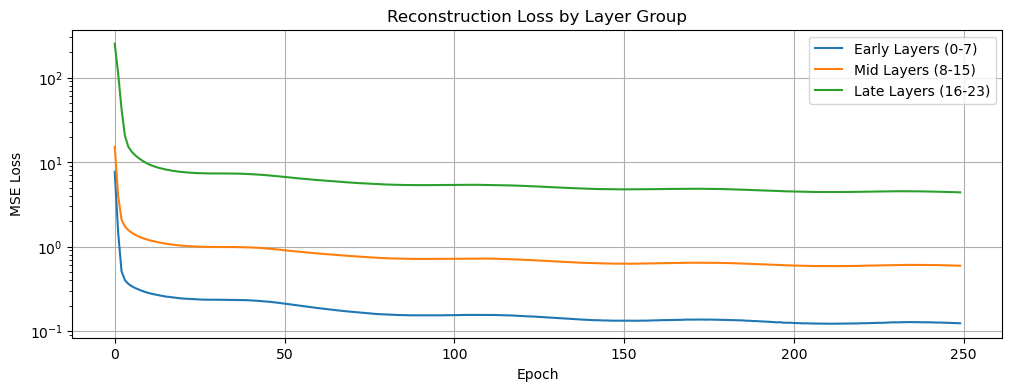

In [ ]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i < 12:
        return 1
    else:
        return 2

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256, dropout_rate=0.1):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_in),
            # No dropout before final output layer
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Cosine Annealing Schedulers
T_max = 30  # Length of a cosine cycle in epochs
eta_min = 3e-6  # Minimum learning rate
schedulers = [CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min) for optimizer in optimizers]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    indices = torch.randperm(acts.shape[0])
    shuffled_acts = acts[indices]
    
    losses = []
    n_batches = shuffled_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = shuffled_acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    # update the learning rates for all schedulers
    [scheduler.step() for scheduler in schedulers]

    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(250)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

Pass the autoencoders to the similarity learner.

In [ ]:
from copy import deepcopy
cloned_encoders = [deepcopy(e).encode for e in encoders]

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=512).to('cuda:0')
# similarity_learner = SimilarityLearner([Autoencoder(i) for i in range(24)], d_hidden=512).to('cuda:0')
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-5)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=32):
    indices = torch.randperm(first_acts.shape[0])
    shuffled_first = first_acts[indices]
    shuffled_second = second_acts[indices]
    shuffled_scores = scores[indices]

    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = shuffled_first[start_idx:end_idx].cuda()
        x2_batch = shuffled_second[start_idx:end_idx].cuda()
        scores_batch = shuffled_scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)
        
        loss = F.mse_loss(sims, scores_batch)        
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(150)):
    # Training
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Loss: {loss:.4f}")
            print(f"Train correlation: {train_corr:.4f}")
            print(f"Test correlation: {test_corr:.4f}\n")

  7%|▋         | 10/150 [02:20<33:02, 14.16s/it]

Epoch 10
Loss: 0.0248
Train correlation: 0.8798
Test correlation: 0.6923



 13%|█▎        | 20/150 [04:41<30:28, 14.07s/it]

Epoch 20
Loss: 0.0140
Train correlation: 0.9368
Test correlation: 0.7224



 20%|██        | 30/150 [07:01<28:29, 14.24s/it]

Epoch 30
Loss: 0.0096
Train correlation: 0.9613
Test correlation: 0.7274



 27%|██▋       | 40/150 [09:22<25:51, 14.11s/it]

Epoch 40
Loss: 0.0067
Train correlation: 0.9717
Test correlation: 0.7360



 33%|███▎      | 50/150 [11:42<23:35, 14.15s/it]

Epoch 50
Loss: 0.0053
Train correlation: 0.9783
Test correlation: 0.7338



 40%|████      | 60/150 [14:03<21:17, 14.19s/it]

Epoch 60
Loss: 0.0042
Train correlation: 0.9821
Test correlation: 0.7370



 47%|████▋     | 70/150 [16:23<18:36, 13.95s/it]

Epoch 70
Loss: 0.0037
Train correlation: 0.9828
Test correlation: 0.7389



 53%|█████▎    | 80/150 [18:44<16:35, 14.23s/it]

Epoch 80
Loss: 0.0029
Train correlation: 0.9861
Test correlation: 0.7419



 60%|██████    | 90/150 [21:04<14:14, 14.24s/it]

Epoch 90
Loss: 0.0025
Train correlation: 0.9858
Test correlation: 0.7392



 67%|██████▋   | 100/150 [23:25<11:48, 14.16s/it]

Epoch 100
Loss: 0.0024
Train correlation: 0.9891
Test correlation: 0.7397



 73%|███████▎  | 110/150 [25:46<09:25, 14.14s/it]

Epoch 110
Loss: 0.0020
Train correlation: 0.9874
Test correlation: 0.7379



 80%|████████  | 120/150 [28:06<07:00, 14.02s/it]

Epoch 120
Loss: 0.0018
Train correlation: 0.9903
Test correlation: 0.7430



 87%|████████▋ | 130/150 [30:27<04:44, 14.24s/it]

Epoch 130
Loss: 0.0017
Train correlation: 0.9889
Test correlation: 0.7450



 93%|█████████▎| 140/150 [32:48<02:21, 14.13s/it]

Epoch 140
Loss: 0.0016
Train correlation: 0.9895
Test correlation: 0.7453



100%|██████████| 150/150 [35:10<00:00, 14.07s/it]

Epoch 150
Loss: 0.0014
Train correlation: 0.9913
Test correlation: 0.7435



### Result: No significant improvement.

### Using Reduce On Plateau

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

  4%|▍         | 10/250 [03:56<1:34:38, 23.66s/it]


Epoch 10
Train Losses - Early: 0.288, Mid: 1.223, Late: 9.787
Test Losses  - Early: 1.433, Mid: 5.247, Late: 27.242


  8%|▊         | 20/250 [07:44<1:27:02, 22.71s/it]


Epoch 20
Train Losses - Early: 0.235, Mid: 1.000, Late: 7.352
Test Losses  - Early: 1.336, Mid: 4.815, Late: 22.754


 12%|█▏        | 30/250 [11:25<1:20:11, 21.87s/it]


Epoch 30
Train Losses - Early: 0.205, Mid: 0.893, Late: 6.560
Test Losses  - Early: 1.298, Mid: 4.652, Late: 21.595


 16%|█▌        | 40/250 [15:03<1:17:14, 22.07s/it]


Epoch 40
Train Losses - Early: 0.185, Mid: 0.823, Late: 6.108
Test Losses  - Early: 1.280, Mid: 4.563, Late: 21.170


 20%|██        | 50/250 [18:46<1:14:41, 22.41s/it]


Epoch 50
Train Losses - Early: 0.171, Mid: 0.771, Late: 5.765
Test Losses  - Early: 1.275, Mid: 4.527, Late: 20.901


 24%|██▍       | 60/250 [22:28<1:10:07, 22.15s/it]


Epoch 60
Train Losses - Early: 0.161, Mid: 0.731, Late: 5.509
Test Losses  - Early: 1.276, Mid: 4.459, Late: 20.691


 28%|██▊       | 70/250 [26:10<1:06:34, 22.19s/it]


Epoch 70
Train Losses - Early: 0.153, Mid: 0.702, Late: 5.297
Test Losses  - Early: 1.278, Mid: 4.453, Late: 20.591


 32%|███▏      | 80/250 [29:54<1:03:35, 22.45s/it]


Epoch 80
Train Losses - Early: 0.148, Mid: 0.678, Late: 5.125
Test Losses  - Early: 1.285, Mid: 4.425, Late: 20.917


 36%|███▌      | 90/250 [33:41<1:00:50, 22.81s/it]


Epoch 90
Train Losses - Early: 0.143, Mid: 0.659, Late: 4.986
Test Losses  - Early: 1.288, Mid: 4.409, Late: 20.605


 40%|████      | 100/250 [37:24<55:01, 22.01s/it] 


Epoch 100
Train Losses - Early: 0.139, Mid: 0.644, Late: 4.870
Test Losses  - Early: 1.293, Mid: 4.419, Late: 20.772


 44%|████▍     | 110/250 [40:57<49:57, 21.41s/it]


Epoch 110
Train Losses - Early: 0.135, Mid: 0.632, Late: 4.757
Test Losses  - Early: 1.303, Mid: 4.372, Late: 20.911


 48%|████▊     | 120/250 [44:31<46:32, 21.48s/it]


Epoch 120
Train Losses - Early: 0.133, Mid: 0.621, Late: 4.661
Test Losses  - Early: 1.307, Mid: 4.374, Late: 20.875


 52%|█████▏    | 130/250 [48:08<43:47, 21.90s/it]


Epoch 130
Train Losses - Early: 0.130, Mid: 0.612, Late: 4.575
Test Losses  - Early: 1.316, Mid: 4.347, Late: 20.805


 56%|█████▌    | 140/250 [51:41<39:08, 21.35s/it]


Epoch 140
Train Losses - Early: 0.128, Mid: 0.604, Late: 4.488
Test Losses  - Early: 1.321, Mid: 4.315, Late: 20.967


 60%|██████    | 150/250 [55:14<35:35, 21.36s/it]


Epoch 150
Train Losses - Early: 0.126, Mid: 0.596, Late: 4.416
Test Losses  - Early: 1.323, Mid: 4.328, Late: 20.908


 64%|██████▍   | 160/250 [58:47<32:00, 21.34s/it]


Epoch 160
Train Losses - Early: 0.124, Mid: 0.591, Late: 4.352
Test Losses  - Early: 1.324, Mid: 4.351, Late: 20.732


 68%|██████▊   | 170/250 [1:02:20<28:31, 21.39s/it]


Epoch 170
Train Losses - Early: 0.123, Mid: 0.585, Late: 4.291
Test Losses  - Early: 1.322, Mid: 4.291, Late: 20.878


 72%|███████▏  | 180/250 [1:05:54<24:51, 21.30s/it]


Epoch 180
Train Losses - Early: 0.121, Mid: 0.580, Late: 4.231
Test Losses  - Early: 1.321, Mid: 4.298, Late: 20.908


 76%|███████▌  | 190/250 [1:09:27<21:17, 21.29s/it]


Epoch 190
Train Losses - Early: 0.119, Mid: 0.576, Late: 4.183
Test Losses  - Early: 1.328, Mid: 4.309, Late: 21.109


 80%|████████  | 200/250 [1:12:59<17:44, 21.30s/it]


Epoch 200
Train Losses - Early: 0.118, Mid: 0.571, Late: 4.141
Test Losses  - Early: 1.327, Mid: 4.298, Late: 21.178


 84%|████████▍ | 210/250 [1:16:33<14:15, 21.38s/it]


Epoch 210
Train Losses - Early: 0.118, Mid: 0.568, Late: 4.102
Test Losses  - Early: 1.330, Mid: 4.241, Late: 21.085


 88%|████████▊ | 220/250 [1:20:07<10:43, 21.45s/it]


Epoch 220
Train Losses - Early: 0.116, Mid: 0.565, Late: 4.054
Test Losses  - Early: 1.325, Mid: 4.286, Late: 21.033


 92%|█████████▏| 230/250 [1:23:41<07:06, 21.34s/it]


Epoch 230
Train Losses - Early: 0.115, Mid: 0.561, Late: 4.014
Test Losses  - Early: 1.324, Mid: 4.244, Late: 21.222


 96%|█████████▌| 240/250 [1:27:14<03:33, 21.38s/it]


Epoch 240
Train Losses - Early: 0.115, Mid: 0.558, Late: 3.983
Test Losses  - Early: 1.323, Mid: 4.260, Late: 20.855


100%|██████████| 250/250 [1:30:48<00:00, 21.79s/it]


Epoch 250
Train Losses - Early: 0.114, Mid: 0.556, Late: 3.950
Test Losses  - Early: 1.330, Mid: 4.243, Late: 20.873


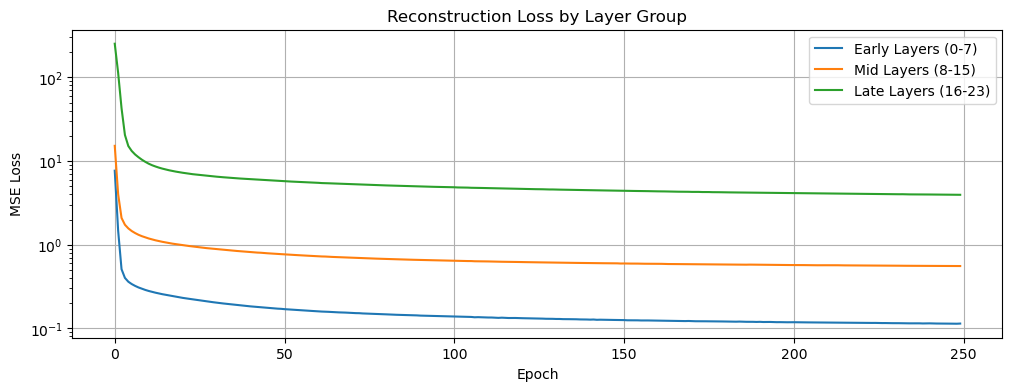

In [ ]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i < 12:
        return 1
    else:
        return 2

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256, dropout_rate=0.1):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_in),
            # No dropout before final output layer
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Patience of 20 epochs before reducing LR, reduce LR by factor of 0.2
reduce_on_plateau_schedulers = [
    ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=20, min_lr=1e-6, verbose=True)
    for optimizer in optimizers
]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    indices = torch.randperm(acts.shape[0])
    shuffled_acts = acts[indices]
    
    losses = []
    n_batches = shuffled_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = shuffled_acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    # Aggregate losses per layer
    mean_losses_per_layer = np.mean(losses, axis=0)

    # Update learning rates for all schedulers based on the mean loss per layer
    for i, scheduler in enumerate(schedulers):
        scheduler.step(mean_losses_per_layer[i])

    return mean_losses_per_layer

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(250)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: No significant improvement.

## Attempting Mitigations Against Overfitting

### Add weight decay to the siamese optimizer to reduce overfitting

In [ ]:
from copy import deepcopy
cloned_encoders = [deepcopy(e).encode for e in encoders]

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=512).to('cuda:0')
# similarity_learner = SimilarityLearner([Autoencoder(i) for i in range(24)], d_hidden=512).to('cuda:0')

# a weight decay term is added in the optimizer
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-5, weight_decay = 1e-4)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=32):
    indices = torch.randperm(first_acts.shape[0])
    shuffled_first = first_acts[indices]
    shuffled_second = second_acts[indices]
    shuffled_scores = scores[indices]

    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = shuffled_first[start_idx:end_idx].cuda()
        x2_batch = shuffled_second[start_idx:end_idx].cuda()
        scores_batch = shuffled_scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)
        
        loss = F.mse_loss(sims, scores_batch)        
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(150)):
    # Training
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Loss: {loss:.4f}")
            print(f"Train correlation: {train_corr:.4f}")
            print(f"Test correlation: {test_corr:.4f}\n")

  7%|▋         | 10/150 [02:23<33:55, 14.54s/it]

Epoch 10
Loss: 0.0283
Train correlation: 0.8544
Test correlation: 0.6778



 13%|█▎        | 20/150 [04:47<31:15, 14.43s/it]

Epoch 20
Loss: 0.0179
Train correlation: 0.9212
Test correlation: 0.7143



 20%|██        | 30/150 [07:11<28:48, 14.40s/it]

Epoch 30
Loss: 0.0135
Train correlation: 0.9383
Test correlation: 0.7243



 27%|██▋       | 40/150 [09:34<26:13, 14.30s/it]

Epoch 40
Loss: 0.0115
Train correlation: 0.9503
Test correlation: 0.7239



 33%|███▎      | 50/150 [11:59<24:17, 14.57s/it]

Epoch 50
Loss: 0.0103
Train correlation: 0.9544
Test correlation: 0.7240



 40%|████      | 60/150 [14:23<22:02, 14.69s/it]

Epoch 60
Loss: 0.0091
Train correlation: 0.9638
Test correlation: 0.7287



 47%|████▋     | 70/150 [16:47<19:28, 14.60s/it]

Epoch 70
Loss: 0.0082
Train correlation: 0.9641
Test correlation: 0.7279



 53%|█████▎    | 80/150 [19:10<16:49, 14.42s/it]

Epoch 80
Loss: 0.0076
Train correlation: 0.9607
Test correlation: 0.7227



 60%|██████    | 90/150 [21:34<14:33, 14.55s/it]

Epoch 90
Loss: 0.0071
Train correlation: 0.9589
Test correlation: 0.7116



 67%|██████▋   | 100/150 [23:58<12:02, 14.45s/it]

Epoch 100
Loss: 0.0064
Train correlation: 0.9609
Test correlation: 0.7143



 73%|███████▎  | 110/150 [26:22<09:37, 14.44s/it]

Epoch 110
Loss: 0.0064
Train correlation: 0.9641
Test correlation: 0.7145



 80%|████████  | 120/150 [28:46<07:13, 14.46s/it]

Epoch 120
Loss: 0.0059
Train correlation: 0.9555
Test correlation: 0.7011



 87%|████████▋ | 130/150 [31:10<04:47, 14.35s/it]

Epoch 130
Loss: 0.0055
Train correlation: 0.9579
Test correlation: 0.6951



 93%|█████████▎| 140/150 [33:34<02:23, 14.35s/it]

Epoch 140
Loss: 0.0051
Train correlation: 0.9603
Test correlation: 0.6979



100%|██████████| 150/150 [35:57<00:00, 14.39s/it]

Epoch 150
Loss: 0.0048
Train correlation: 0.9629
Test correlation: 0.7018



### Result: Significantly worse performance for both train and test.

### Increase Dropout Rate from .1 to .2

  4%|▍         | 10/250 [03:51<1:32:12, 23.05s/it]


Epoch 10
Train Losses - Early: 0.336, Mid: 1.455, Late: 11.221
Test Losses  - Early: 1.503, Mid: 5.600, Late: 28.316


  8%|▊         | 20/250 [07:33<1:24:37, 22.08s/it]


Epoch 20
Train Losses - Early: 0.285, Mid: 1.255, Late: 9.099
Test Losses  - Early: 1.431, Mid: 5.374, Late: 24.909


 12%|█▏        | 30/250 [11:11<1:20:10, 21.87s/it]


Epoch 30
Train Losses - Early: 0.258, Mid: 1.163, Late: 8.385
Test Losses  - Early: 1.437, Mid: 5.494, Late: 24.807


 16%|█▌        | 40/250 [14:52<1:17:00, 22.00s/it]


Epoch 40
Train Losses - Early: 0.241, Mid: 1.098, Late: 7.931
Test Losses  - Early: 1.471, Mid: 5.641, Late: 25.144


 20%|██        | 50/250 [18:31<1:12:54, 21.87s/it]


Epoch 50
Train Losses - Early: 0.228, Mid: 1.050, Late: 7.608
Test Losses  - Early: 1.508, Mid: 5.795, Late: 26.037


 24%|██▍       | 60/250 [22:09<1:09:00, 21.79s/it]


Epoch 60
Train Losses - Early: 0.218, Mid: 1.011, Late: 7.355
Test Losses  - Early: 1.563, Mid: 6.002, Late: 26.746


 28%|██▊       | 70/250 [25:47<1:05:43, 21.91s/it]


Epoch 70
Train Losses - Early: 0.210, Mid: 0.979, Late: 7.143
Test Losses  - Early: 1.623, Mid: 6.200, Late: 27.453


 32%|███▏      | 80/250 [29:29<1:02:31, 22.07s/it]


Epoch 80
Train Losses - Early: 0.204, Mid: 0.954, Late: 6.963
Test Losses  - Early: 1.666, Mid: 6.289, Late: 27.964


 36%|███▌      | 90/250 [33:07<58:01, 21.76s/it]  


Epoch 90
Train Losses - Early: 0.199, Mid: 0.931, Late: 6.809
Test Losses  - Early: 1.710, Mid: 6.382, Late: 28.933


 40%|████      | 100/250 [36:44<54:23, 21.76s/it]


Epoch 100
Train Losses - Early: 0.194, Mid: 0.913, Late: 6.670
Test Losses  - Early: 1.774, Mid: 6.483, Late: 29.180


 44%|████▍     | 110/250 [40:20<50:09, 21.50s/it]


Epoch 110
Train Losses - Early: 0.190, Mid: 0.898, Late: 6.561
Test Losses  - Early: 1.808, Mid: 6.542, Late: 29.977


 48%|████▊     | 120/250 [44:01<47:32, 21.94s/it]


Epoch 120
Train Losses - Early: 0.187, Mid: 0.884, Late: 6.453
Test Losses  - Early: 1.854, Mid: 6.579, Late: 30.747


 52%|█████▏    | 130/250 [47:39<43:46, 21.88s/it]


Epoch 130
Train Losses - Early: 0.184, Mid: 0.873, Late: 6.354
Test Losses  - Early: 1.883, Mid: 6.578, Late: 30.826


 56%|█████▌    | 140/250 [51:20<40:37, 22.16s/it]


Epoch 140
Train Losses - Early: 0.181, Mid: 0.865, Late: 6.278
Test Losses  - Early: 1.889, Mid: 6.616, Late: 31.898


 60%|██████    | 150/250 [55:00<36:54, 22.15s/it]


Epoch 150
Train Losses - Early: 0.179, Mid: 0.853, Late: 6.200
Test Losses  - Early: 1.920, Mid: 6.583, Late: 32.489


 64%|██████▍   | 160/250 [58:43<33:30, 22.34s/it]


Epoch 160
Train Losses - Early: 0.177, Mid: 0.846, Late: 6.131
Test Losses  - Early: 1.944, Mid: 6.575, Late: 32.313


 68%|██████▊   | 170/250 [1:02:24<29:26, 22.08s/it]


Epoch 170
Train Losses - Early: 0.175, Mid: 0.839, Late: 6.072
Test Losses  - Early: 1.919, Mid: 6.496, Late: 33.389


 72%|███████▏  | 180/250 [1:06:05<25:56, 22.24s/it]


Epoch 180
Train Losses - Early: 0.173, Mid: 0.832, Late: 6.016
Test Losses  - Early: 1.948, Mid: 6.535, Late: 33.764


 76%|███████▌  | 190/250 [1:09:47<22:15, 22.26s/it]


Epoch 190
Train Losses - Early: 0.172, Mid: 0.828, Late: 5.965
Test Losses  - Early: 1.938, Mid: 6.494, Late: 34.401


 80%|████████  | 200/250 [1:13:30<18:38, 22.37s/it]


Epoch 200
Train Losses - Early: 0.171, Mid: 0.822, Late: 5.916
Test Losses  - Early: 1.946, Mid: 6.484, Late: 34.815


 84%|████████▍ | 210/250 [1:17:14<14:53, 22.33s/it]


Epoch 210
Train Losses - Early: 0.170, Mid: 0.818, Late: 5.876
Test Losses  - Early: 1.937, Mid: 6.526, Late: 34.935


 88%|████████▊ | 220/250 [1:20:54<11:01, 22.04s/it]


Epoch 220
Train Losses - Early: 0.169, Mid: 0.814, Late: 5.834
Test Losses  - Early: 1.936, Mid: 6.436, Late: 35.078


 92%|█████████▏| 230/250 [1:24:33<07:20, 22.03s/it]


Epoch 230
Train Losses - Early: 0.168, Mid: 0.810, Late: 5.792
Test Losses  - Early: 1.926, Mid: 6.514, Late: 35.921


 96%|█████████▌| 240/250 [1:28:14<03:42, 22.29s/it]


Epoch 240
Train Losses - Early: 0.167, Mid: 0.805, Late: 5.759
Test Losses  - Early: 1.936, Mid: 6.447, Late: 35.847


100%|██████████| 250/250 [1:31:56<00:00, 22.07s/it]


Epoch 250
Train Losses - Early: 0.166, Mid: 0.803, Late: 5.716
Test Losses  - Early: 1.929, Mid: 6.454, Late: 36.050


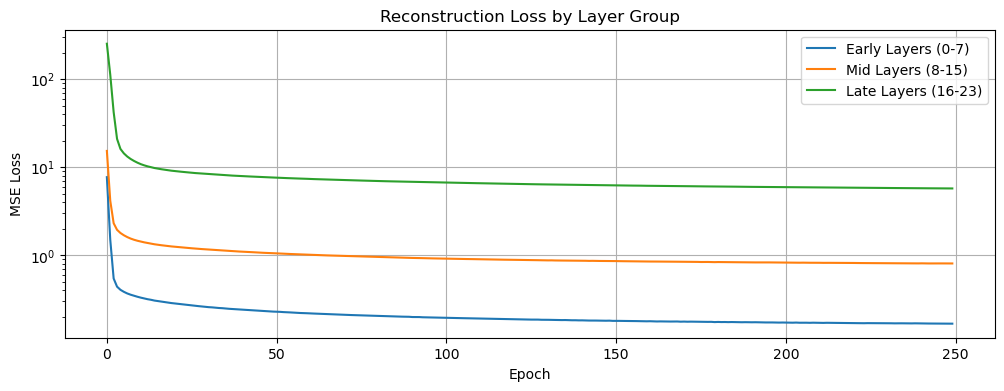

In [ ]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i < 12:
        return 1
    else:
        return 2

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256, dropout_rate=0.2):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_in),
            # No dropout before final output layer
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    indices = torch.randperm(acts.shape[0])
    shuffled_acts = acts[indices]
    
    losses = []
    n_batches = shuffled_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = shuffled_acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(250)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Significantly worse performance.

### Attempt at Implementing KL Divergence

Theoretically, integrating KL divergence into the loss function could make latent representations smoother and more generlizable, and therefore have better similarity predictions when training the siamese network.

  4%|▍         | 10/250 [04:52<1:56:57, 29.24s/it]


Epoch 10
Train Losses - Early: 0.290, Mid: inf, Late: inf
Test Losses  - Early: 1.437, Mid: 5.246, Late: 26.999


  8%|▊         | 20/250 [09:49<1:54:32, 29.88s/it]


Epoch 20
Train Losses - Early: 0.241, Mid: inf, Late: inf
Test Losses  - Early: 1.343, Mid: 4.827, Late: 22.767


 12%|█▏        | 30/250 [14:43<1:47:12, 29.24s/it]


Epoch 30
Train Losses - Early: inf, Mid: 0.901, Late: inf
Test Losses  - Early: 1.312, Mid: 4.664, Late: 21.629


 16%|█▌        | 40/250 [19:31<1:42:07, 29.18s/it]


Epoch 40
Train Losses - Early: 0.192, Mid: 0.835, Late: inf
Test Losses  - Early: 1.309, Mid: 4.603, Late: 20.996


 20%|██        | 50/250 [24:19<1:36:32, 28.96s/it]


Epoch 50
Train Losses - Early: 0.179, Mid: 0.785, Late: inf
Test Losses  - Early: 1.301, Mid: 4.552, Late: 20.664


 24%|██▍       | 60/250 [29:04<1:30:32, 28.59s/it]


Epoch 60
Train Losses - Early: 0.170, Mid: 0.747, Late: inf
Test Losses  - Early: 1.296, Mid: 4.478, Late: 20.652


 28%|██▊       | 70/250 [33:51<1:25:24, 28.47s/it]


Epoch 70
Train Losses - Early: 0.162, Mid: 0.718, Late: inf
Test Losses  - Early: 1.306, Mid: 4.487, Late: 20.636


 32%|███▏      | 80/250 [38:34<1:20:30, 28.42s/it]


Epoch 80
Train Losses - Early: 0.156, Mid: 0.694, Late: inf
Test Losses  - Early: 1.319, Mid: 4.464, Late: 20.560


 36%|███▌      | 90/250 [43:21<1:15:59, 28.49s/it]


Epoch 90
Train Losses - Early: 0.152, Mid: 0.676, Late: inf
Test Losses  - Early: 1.323, Mid: 4.416, Late: 20.561


 40%|████      | 100/250 [48:05<1:11:30, 28.60s/it]


Epoch 100
Train Losses - Early: 0.147, Mid: 0.659, Late: inf
Test Losses  - Early: 1.325, Mid: 4.436, Late: 20.901


 44%|████▍     | 110/250 [52:51<1:06:41, 28.58s/it]


Epoch 110
Train Losses - Early: 0.144, Mid: 0.647, Late: inf
Test Losses  - Early: 1.328, Mid: 4.420, Late: 20.651


 48%|████▊     | 120/250 [57:36<1:01:47, 28.52s/it]


Epoch 120
Train Losses - Early: 0.141, Mid: 0.636, Late: inf
Test Losses  - Early: 1.333, Mid: 4.382, Late: 20.622


 52%|█████▏    | 130/250 [1:02:21<57:03, 28.53s/it]


Epoch 130
Train Losses - Early: 0.138, Mid: 0.627, Late: inf
Test Losses  - Early: 1.345, Mid: 4.390, Late: 20.582


 56%|█████▌    | 140/250 [1:07:07<52:30, 28.64s/it]


Epoch 140
Train Losses - Early: 0.136, Mid: 0.619, Late: inf
Test Losses  - Early: 1.341, Mid: 4.367, Late: 20.679


 60%|██████    | 150/250 [1:11:54<47:44, 28.65s/it]


Epoch 150
Train Losses - Early: 0.133, Mid: 0.611, Late: inf
Test Losses  - Early: 1.345, Mid: 4.361, Late: 20.842


 64%|██████▍   | 160/250 [1:16:38<42:50, 28.56s/it]


Epoch 160
Train Losses - Early: 0.132, Mid: 0.605, Late: inf
Test Losses  - Early: 1.340, Mid: 4.355, Late: 21.077


 68%|██████▊   | 170/250 [1:21:32<39:14, 29.43s/it]


Epoch 170
Train Losses - Early: 0.131, Mid: 0.601, Late: inf
Test Losses  - Early: 1.348, Mid: 4.371, Late: 21.029


 72%|███████▏  | 180/250 [1:26:22<33:47, 28.96s/it]


Epoch 180
Train Losses - Early: 0.129, Mid: 0.595, Late: inf
Test Losses  - Early: 1.341, Mid: 4.337, Late: 20.920


 76%|███████▌  | 190/250 [1:31:10<28:47, 28.79s/it]


Epoch 190
Train Losses - Early: 0.128, Mid: 0.590, Late: inf
Test Losses  - Early: 1.344, Mid: 4.356, Late: 21.193


 80%|████████  | 200/250 [1:35:59<24:05, 28.91s/it]


Epoch 200
Train Losses - Early: 0.127, Mid: 0.587, Late: inf
Test Losses  - Early: 1.344, Mid: 4.303, Late: 21.112


 84%|████████▍ | 210/250 [2:44:43<1:49:40, 164.52s/it]  


Epoch 210
Train Losses - Early: 0.125, Mid: 0.581, Late: inf
Test Losses  - Early: 1.338, Mid: 4.304, Late: 21.047


 88%|████████▊ | 220/250 [2:49:36<16:28, 32.96s/it]   


Epoch 220
Train Losses - Early: 0.124, Mid: 0.579, Late: inf
Test Losses  - Early: 1.342, Mid: 4.288, Late: 21.084


 92%|█████████▏| 230/250 [2:54:30<09:54, 29.74s/it]


Epoch 230
Train Losses - Early: 0.124, Mid: 0.575, Late: 4.034
Test Losses  - Early: 1.342, Mid: 4.299, Late: 21.102


 96%|█████████▌| 240/250 [2:59:28<04:57, 29.80s/it]


Epoch 240
Train Losses - Early: 0.123, Mid: 0.571, Late: inf
Test Losses  - Early: 1.337, Mid: 4.286, Late: 21.626


100%|██████████| 250/250 [3:04:26<00:00, 44.26s/it]


Epoch 250
Train Losses - Early: 0.122, Mid: 0.568, Late: inf
Test Losses  - Early: 1.340, Mid: 4.284, Late: 21.139


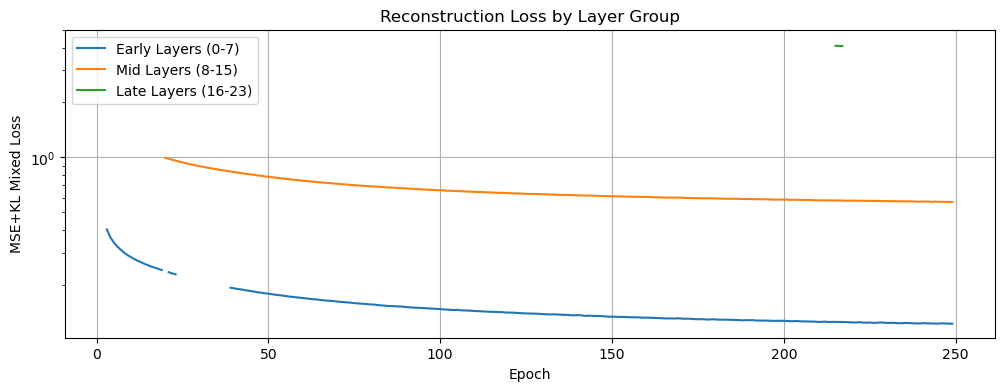

In [ ]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i < 12:
        return 1
    else:
        return 2

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256, dropout_rate=0.1):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_in),
            # No dropout before final output layer
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)

    # change forward pass to return latent representation (formerly h) and the reconstructed input (formerly the sole return)
    def forward(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return latent, reconstructed
    
# create the kl divergence loss
def kl_divergence_loss(latent):
    # standard normal, mean 0 std dev 1
    mean = torch.mean(latent, dim = 0) # across the batch
    std = torch.std(latent, dim = 0) # across the batch

    # the KL divergence formula
    kl_loss = -0.5 * torch.sum(1 + torch.log(std**2) - mean**2 - std**2)

    # normalize by the batch size
    return kl_loss / latent.shape[0]

# create the loss function with kl integrated
def autoencoder_loss_with_kl(reconstructed, original, latent):
    # the reconstruction loss is mse
    reconstruction_loss = F.mse_loss(reconstructed, original)

    # create KL
    kl_loss = kl_divergence_loss(latent)

    # create a weighted combo
    return reconstruction_loss + 1e-3 * kl_loss

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    indices = torch.randperm(acts.shape[0])
    shuffled_acts = acts[indices]
    
    losses = []
    n_batches = shuffled_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = shuffled_acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()

            # get the reconstruction of the input and the latent
            latent, reconstructed = model(batch_i)
            # find the modified loss
            loss = autoencoder_loss_with_kl(reconstructed, batch_i, latent)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(250)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_losses = []
            for i in range(n_layers):
                latent, reconstructed = encoders[i](all_test_acts[:, i].cuda())
                
                # Compute reconstruction loss (MSE) and KL divergence
                reconstruction_loss = F.mse_loss(reconstructed.cpu(), all_test_acts[:, i])
                kl_loss = kl_divergence_loss(latent.cpu())
                
                # Combine losses as in training
                combined_loss = reconstruction_loss + 1e-3 * kl_loss
                test_losses.append(combined_loss.item())
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE+KL Mixed Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

Noticeably unstable training.

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, mlp):
        super().__init__()
        self.mlp = mlp

    def forward(self, x1, x2):
        h1 = self.mlp(x1)
        h2 = self.mlp(x2)
        return F.cosine_similarity(h1, h2, dim=-1)

class LayerwiseSiameseNetworks(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256):
        super().__init__()
        self.n_layers = n_layers
        self.layer_nets = nn.ModuleList([SiameseNetwork(encoders[i]) for i in range(n_layers)])

    def forward(self, x1, x2):
        similarities = []
        for layer in range(self.n_layers):
            net_at_layer = self.layer_nets[layer].cuda()
            # Get the activations at the given layer
            x1_l = x1[:, layer].cuda()
            x2_l = x2[:, layer].cuda()

            sim_at_layer = net_at_layer(x1_l, x2_l)
            # print(sim_at_layer.shape)
            similarities.append(sim_at_layer)

        return torch.stack(similarities, dim=-1)

class SimilarityLearner(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256, d_out_hidden=512, dropout=0.1):
        super().__init__()
        self.layer_nets = LayerwiseSiameseNetworks(encoders, n_layers, d_in, d_hidden)

        self.mlp = nn.Sequential(
            nn.Linear(n_layers, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, 1),
            nn.Hardsigmoid()
        )

    def forward(self, x1, x2, training=True):
        layerwise_similarities = self.layer_nets(x1, x2)
        similarity = self.mlp(layerwise_similarities)
        return similarity.squeeze()

In [ ]:
from copy import deepcopy
cloned_encoders = [deepcopy(e).encode for e in encoders]

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=512).to('cuda:0')
# similarity_learner = SimilarityLearner([Autoencoder(i) for i in range(24)], d_hidden=512).to('cuda:0')
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-5)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=32):
    indices = torch.randperm(first_acts.shape[0])
    shuffled_first = first_acts[indices]
    shuffled_second = second_acts[indices]
    shuffled_scores = scores[indices]

    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = shuffled_first[start_idx:end_idx].cuda()
        x2_batch = shuffled_second[start_idx:end_idx].cuda()
        scores_batch = shuffled_scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)
        
        loss = F.mse_loss(sims, scores_batch)        
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(150)):
    # Training
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Loss: {loss:.4f}")
            print(f"Train correlation: {train_corr:.4f}")
            print(f"Test correlation: {test_corr:.4f}\n")

  7%|▋         | 10/150 [02:23<33:29, 14.35s/it]

Epoch 10
Loss: 0.0266
Train correlation: 0.8664
Test correlation: 0.6893



 13%|█▎        | 20/150 [04:44<30:46, 14.20s/it]

Epoch 20
Loss: 0.0170
Train correlation: 0.9235
Test correlation: 0.7208



 20%|██        | 30/150 [07:05<28:16, 14.14s/it]

Epoch 30
Loss: 0.0116
Train correlation: 0.9484
Test correlation: 0.7276



 27%|██▋       | 40/150 [09:26<26:15, 14.32s/it]

Epoch 40
Loss: 0.0085
Train correlation: 0.9651
Test correlation: 0.7290



 33%|███▎      | 50/150 [11:48<23:40, 14.20s/it]

Epoch 50
Loss: 0.0065
Train correlation: 0.9703
Test correlation: 0.7298



 40%|████      | 60/150 [14:10<21:13, 14.15s/it]

Epoch 60
Loss: 0.0053
Train correlation: 0.9782
Test correlation: 0.7354



 47%|████▋     | 70/150 [16:33<19:12, 14.40s/it]

Epoch 70
Loss: 0.0044
Train correlation: 0.9808
Test correlation: 0.7371



 53%|█████▎    | 80/150 [18:52<16:19, 14.00s/it]

Epoch 80
Loss: 0.0041
Train correlation: 0.9817
Test correlation: 0.7421



 60%|██████    | 90/150 [21:15<14:18, 14.30s/it]

Epoch 90
Loss: 0.0033
Train correlation: 0.9861
Test correlation: 0.7345



 67%|██████▋   | 100/150 [23:35<11:49, 14.18s/it]

Epoch 100
Loss: 0.0030
Train correlation: 0.9861
Test correlation: 0.7392



 73%|███████▎  | 110/150 [25:57<09:29, 14.23s/it]

Epoch 110
Loss: 0.0026
Train correlation: 0.9886
Test correlation: 0.7390



 80%|████████  | 120/150 [28:18<07:08, 14.28s/it]

Epoch 120
Loss: 0.0023
Train correlation: 0.9880
Test correlation: 0.7420



 87%|████████▋ | 130/150 [30:40<04:43, 14.18s/it]

Epoch 130
Loss: 0.0021
Train correlation: 0.9888
Test correlation: 0.7463



 93%|█████████▎| 140/150 [33:02<02:21, 14.18s/it]

Epoch 140
Loss: 0.0020
Train correlation: 0.9900
Test correlation: 0.7434



100%|██████████| 150/150 [35:23<00:00, 14.16s/it]

Epoch 150
Loss: 0.0017
Train correlation: 0.9893
Test correlation: 0.7442



In [ ]:
test_preds = best_model(first_test.cuda(), second_test.cuda(), training=False)
test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]
print(test_corr)

tensor(0.7463, grad_fn=<SelectBackward0>)


In [ ]:
param_count = sum([w.numel() for w in similarity_learner.parameters()])
f"This model has {param_count} parameters!"

'This model has 24606209 parameters!'

### Result: No noticeable improvement.

While this was interesting to try out, a more proper approach would be to actually implement a Variational Autoencoder in the current architecture. However, the formulation of a probability in this use case is likely outside the scope of this project.